## Transporte de um pulso inicial de poluição numa situação em que o vento seja constante
 Alejandro Delgado Peralta


## Exercicio com aproximação de primeiro ordem, progressivo no tempo e regressivo no espaço.
Temos uma equação da adveção em 1D:

$$
\frac{\partial C}{\partial t} + U*\frac{\partial C}{\partial x} = 0,
$$

A condição inicial (CI) dada por uma gaussiana centrada em i=51, com decaimiento exponencial dado por `nr` (número de pontos) onde a amplitude da perturbação cai de um fator e:

$$
C(x,0) = C_{i,0} = C_0 \exp[\frac{-(i\Delta x - 51\Delta x)^2}{(nr*\Delta x)^2}]
$$

CFL:
$$
U*\frac{\Delta t}{\Delta x} < 1
$$

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def Conc(i, idx, nr, Co, dx):
    """
    Função de concentração com variação Gaussiana
    ---------------------------------------------
    i:      index
    idx:    central index
    nr:     número de pontos a partir do centro da gaussiana
    dx:     variação espacial em metros.
    Co:     Concentração do poluente, por exemplo ug/m3 em PM10
    """

    Conc = Co*np.exp(-(i*dx-idx*dx)**2/(nr*dx)**2)

    return Conc

def sol_num(idx, cond_front, fun, hora, Co, dx, U_wind):
    """
    cond_front:     Condição de fronteira, tipo "fixa", "periódica" e "radicional".
    fun:            Função tipo "Gaussiana" e "Retângulo"
    hora:           Tempo em horas (int)
    Co:             Concentração do poluente, por exemplo ug/m3 em PM10
    dx:             Resolução espacial em m
    """

    Nx     = 101                # pontos totais da malha 1D
    Tempo  = hora*3600          # tempo total em segundos
    #dt     = dx/U_wind         # para ter CFL = 1
    dt     = 3*dx/1000          # passo de tempo , 6*dx/1000 baseado na recomendação WRF-Chem
    Nt     = int(Tempo/dt)      # número de passos de tempo
    U_wind                      # vento zonal m/s
    
    CFL = U_wind*dt/dx          # Courant number, ou CFL-number
    C = np.zeros((Nx+1,Nt+1))   # Matriz

    fig, ax = plt.subplots(2,1, figsize=[10,8], sharex = True, gridspec_kw={'hspace':0.1} )
    for j, nr in enumerate([10, 2]):

        # Condições iniciais
        # -------------------
        for i in range(Nx+1):
            if fun == "Gaussiana":
                C[i,0] = Conc(i, idx, nr, Co, dx)

            if fun == "Retângulo":
                C[[int(idx - 2/2), idx, int(idx + 2/2)], 0] = 1/2*Co

        ax[j].plot(C[:,0], color = 'b', lw=3, label="Condição inicial")

        # Aproximação numérica no tempo-espaço e condições de fronteira
        # -------------------------------------------------------------
        for n in range(0, Nt):
   
            if n % 400 == 0:
                ax[j].plot(C[:,n], color='m', linestyle='dashed', label=f"PT {n}")     

            for i in range(1,Nx+1):
                # Aproximação numérica de ordem 1 progressivo no tempo e regressivo no espaço
                C[i,n+1] = C[i, n] - U_wind*dt/dx*(C[i, n]- C[i-1, n])

                # Condição de fronteira
                if cond_front == 'fixa':
                    C[[0,-1], n] = [0,0]

                elif cond_front == 'periódica':
                    C[[0, 1], n+1] = C[[-1,-2],n]
                
                elif cond_front == 'radiacional':
                    C[-1, n] = C[-1, n]

        ax[j].plot(C[:,-1], color='g', lw=3, label = f"Final {Tempo/3600} horas ")
        ax[j].set_ylabel("PM$_{10}$ ($\mu$g.m$^{-3}$)")
    
        ax[j].set_title("Variação da concentração"+f" para $\Delta$t = {dt} segundos, $\Delta$x = {dx} metros e nr = {nr}.",loc='left')
        ax[0].legend(fontsize=8, ncol=2)

        if j == 1:
            ax[j].set_xlabel("Pontos da grade")
            ax[j].text(2,3, r"$\vec U$ = "+ f"{U_wind} m/s.", fontsize=12)
            ax[j].text(2,4, f"CFL = {CFL}", fontsize=12)
        
        fig.suptitle(f"Solução numérica com função {fun} \n e condição de fronteira de tipo {cond_front}", fontweight='bold' )
        fig.savefig(fun + "_" + cond_front +"_" + str(hora) +".png", dpi = 300, bbox_inches='tight', facecolor='w')
    
    return C


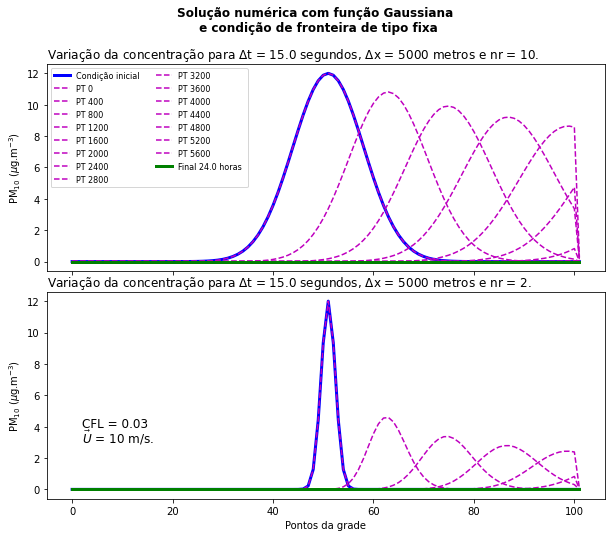

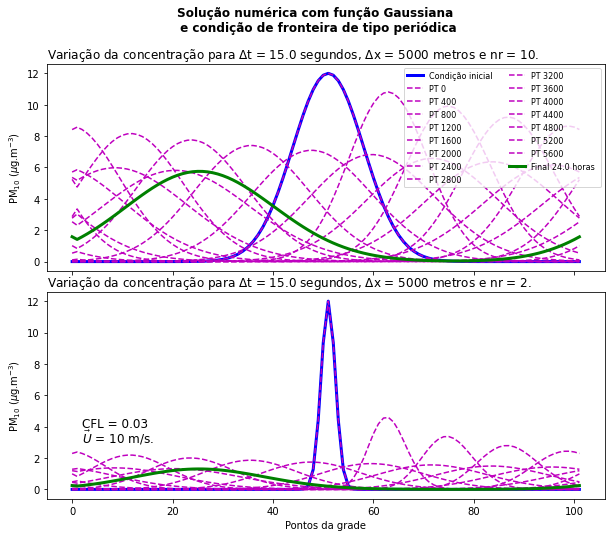

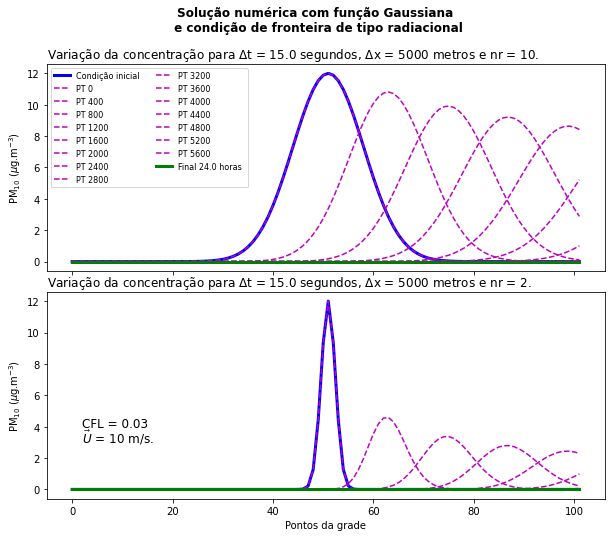

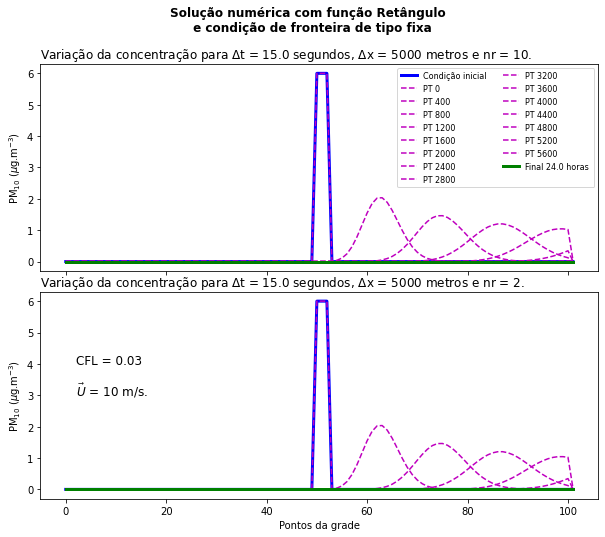

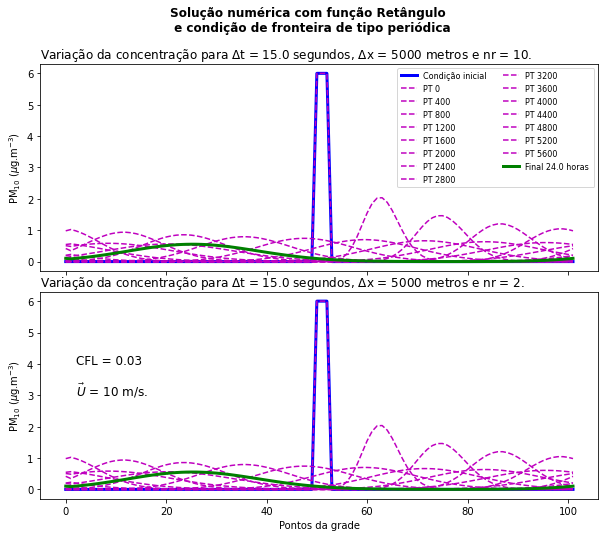

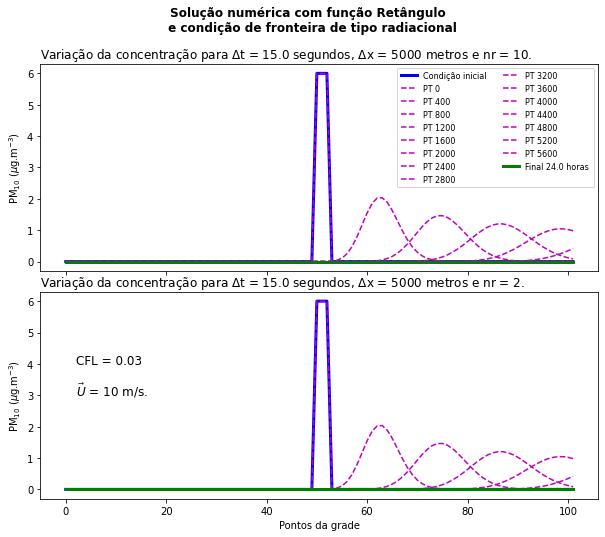

In [6]:
for f in ['Gaussiana', 'Retângulo']:
    for tipo in ['fixa', 'periódica', 'radiacional']:
        
        sol_num(idx=51, 
                cond_front= tipo, 
                fun= f, 
                hora=24, 
                Co=12, 
                dx=5000, 
                U_wind=+10)